In [1]:
### To install sib as a python package look at the sib documentation 

import sys
#sys.path.insert(0,'./src/')
#simulator_path = "../covid_de/sim/" ##change simulatio path here 
sys.path.insert(0,'src/')
simulator_path = "../simulator/sim/" ##change simulatio path here 
sys.path.insert(0, '../simulator/sim/lib/') # we need distributions.py
sys.path.insert(0,simulator_path)
sys.path.insert(0, "../epidemic_mitigation/src/") # correct rankers

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import json, log, logging, loop_mtpp
from importlib import reload
import imp
from math import exp
import pickle
#sys.path.insert(0,'./src/loop_ranker')
from lib.mobilitysim import MobilitySimulator
import loop_mtpp
from mtpp_utils import contacts_cg
from distributions import CovidDistributions



#logging
data_path = '../simulator/sim/lib/mobility/'

output_dir = "output_Tubingen_pop1_site1/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()

Log setup complete


### Mobility simulation

In [2]:
beta = 0.05  # from paper
country = 'GER'
distr = CovidDistributions(country)
# with open(data_path + 'Isle_of_Wight_settings_pop10_site5.pk', 'rb') as fp:
with open(data_path + 'Tubingen_settings_100_20.pk', 'rb') as fp:
    mob_kwargs = pickle.load(fp)

mob_kwargs["delta"] = 0.2554120904376099
T = 50
seed_mob = 2
t_unit = 24
t_res = 0.25  # drop contacts with a duration < t_res (in hours)
max_time = T * t_unit
mob = MobilitySimulator(**mob_kwargs)
mob.verbose = True
out = mob.simulate(max_time=max_time, seed=seed_mob)
N = mob.num_people
# print(N)


Simulate mobility for 1200.00 time units... 

## Set testing and quarantine rules

In [3]:
# n_indiv=np.ceil(mob_kwargs['num_people_unscaled']/mob_kwargs['downsample_pop'])
n_seeds = {'expo': 3, 'iasy': 4, 'ipre': 5}  # select initial infected seeds
num_test_random = 0  # number of random tests per day
fraction_sym_obs = 0.05  # fraction of Symptomatic tested positive
initial_steps = 5  # starting time of intervention
delta_days = 1  # intervention every delta_days days
test_HH = False
quarantine_HH = True
adoption_fraction = 1.0
probability_th = 0.0005
adapt_th = False



## Set the inference algorithm class

In [4]:
import matplotlib.pyplot as plt
import sib
import scipy

from rankers import sib_rank, greedy_rank, mean_field_rank
from tqdm.notebook import tqdm
from scipy.stats import gamma
sib.set_num_threads(6)


mu = 1/12
prob_seed = 1/N
prob_sus = 0.5
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1e-6
fp_rate = 0.0
fn_rate = 0.285

rankers = {}


rankers["MF"] = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = mu,
                lamb = 1.0
                )
                
rankers["greedy"] = greedy_rank.GreedyRanker(
                 include_S = True,
                tau=10)

rankers["no_intervention"] = None

k_rec_gamma = 62.484380808876004
scale_rec_gamma = 0.2992112296058585
t0 = distr.incubation_mean_of_lognormal - \
    distr.median_infectious_without_symptom
alpha = 2.0
tau = 7

prob_i = sib.PiecewiseLinear(sib.RealParams(
    list(scipy.special.expit(alpha*(range(T+1) - t0*np.ones(T+1))))))
prob_r = sib.PiecewiseLinear(sib.RealParams(
    list(scipy.stats.gamma.sf(range(T+1), k_rec_gamma, scale=scale_rec_gamma))))

rankers["sib"] = sib_rank.SibRanker(
    params=sib.Params(
        prob_i=prob_i,
        prob_r=prob_r,
        pseed=pseed,
        psus=psus,
        pautoinf=pautoinf),
    maxit0=20,
    maxit1=20,
    tol=1e-3,
    memory_decay=1e-5,
    window_length=21,
    tau=tau,
    fnr=fn_rate,
    fpr=fp_rate

)




In [5]:
ress = {}
for num_test_algo in [300]:  # number of test per day by ranking
    for seed in [42]: # never use seed = 0
        print(num_test_algo, seed)
        for s in list(rankers.keys()):
            data = {"algo": s}
            if s == "no_intervention":
                res_s = loop_mtpp.free_mtpp(mob,
                                            country=country,
                                            beta=beta,
                                            T=T,
                                            seed=seed,
                                            logger=logging.getLogger(
                                                f"iteration.{s}"),
                                            data=data,
                                            initial_counts=n_seeds,
                                            name_file_res=s +
                                            f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                                            output_dir=output_dir,
                                            )
            else:
                res_s = loop_mtpp.loop_mtpp(mob,
                                            rankers[s],
                                            country=country,
                                            T=T,
                                            seed=seed,
                                            logger=logging.getLogger(
                                                f"iteration.{s}"),
                                            data=data,
                                            initial_steps=initial_steps,
                                            num_test_random=num_test_random,
                                            num_test_algo=num_test_algo,
                                            fraction_sym_obs=fraction_sym_obs,
                                            initial_counts=n_seeds,
                                            beta=beta,
                                            test_HH=test_HH,
                                            quarantine_HH=quarantine_HH,
                                            name_file_res=s +
                                            f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                                            output_dir=output_dir,
                                            save_every_iter=1,
                                            adoption_fraction=adoption_fraction,
                                            probability_th=probability_th,
                                            adapt_th=adapt_th,
                                            fp_rate=fp_rate,
                                            fn_rate=fn_rate
                                            )
            ress[s] = res_s
        del res_s


300 42
Starting with guys:  {'expo': [70, 457, 218], 'iasy': [250, 39, 855, 486], 'ipre': [110, 72, 86, 695, 448]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:0
iteration.MF: INFO     adding contacts in the interval [0, 24]
iteration.MF: INFO     number of unique contacts: 2094
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.MF: INFO     AUR_I : 0.652, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)



[Reached max time: 24h (1d)]
All raw contacts 2114
Contacts at midnight  46
Contacts collected by coarse-graining  20
Contacts in multiple days  0
Coarse-grained contacts  2140
Missing contacts  0
Asymmetric contacts  0
t: 48.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:1
iteration.MF: INFO     adding contacts in the interval [24, 48]
iteration.MF: INFO     number of unique contacts: 2096



[Reached max time: 48h (2d)]
All raw contacts 2140
Contacts at midnight  112
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2208
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.MF: INFO     AUR_I : 0.652, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 72.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:2
iteration.MF: INFO     adding contacts in the interval [48, 72]
iteration.MF: INFO     number of unique contacts: 2268



[Reached max time: 72h (3d)]
All raw contacts 2340
Contacts at midnight  144
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2412
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.MF: INFO     AUR_I : 0.652, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 96.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:3



[Reached max time: 96h (4d)]


iteration.MF: INFO     adding contacts in the interval [72, 96]
iteration.MF: INFO     number of unique contacts: 2640
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.MF: INFO     AUR_I : 0.652, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


All raw contacts 2688
Contacts at midnight  144
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2784
Missing contacts  0
Asymmetric contacts  0
t: 120.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:4
iteration.MF: INFO     adding contacts in the interval [96, 120]
iteration.MF: INFO     number of unique contacts: 2532



[Reached max time: 120h (5d)]
All raw contacts 2584
Contacts at midnight  116
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (890.0, 14.0, 0.0)
iteration.MF: INFO     AUR_I : 0.610, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+2)


t: 144.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     
observation-based inference algorithm starts now

iteration.MF: INFO     time:5
iteration.MF: INFO     adding contacts in the interval [120, 144]
iteration.MF: INFO     number of unique contacts: 2498
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.MF: INFO     AUR_I : 0.582, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+3)



[Reached max time: 144h (6d)]
All raw contacts 2538
Contacts at midnight  206
Contacts collected by coarse-graining  40
Contacts in multiple days  0
Coarse-grained contacts  2704
Missing contacts  0
Asymmetric contacts  0
t: 168.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:6



[Reached max time: 168h (7d)]
All raw contacts 2632
Contacts at midnight  206
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2756
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [144, 168]
iteration.MF: INFO     number of unique contacts: 2550
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.MF: INFO     AUR_I : 0.582, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+0)


t: 192.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:7
iteration.MF: INFO     adding contacts in the interval [168, 192]
iteration.MF: INFO     number of unique contacts: 2780



[Reached max time: 192h (8d)]
All raw contacts 2848
Contacts at midnight  142
Contacts collected by coarse-graining  68
Contacts in multiple days  0
Coarse-grained contacts  2922
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (886.0, 18.0, 0.0)
iteration.MF: INFO     AUR_I : 0.555, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (+1)


t: 216.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:8
iteration.MF: INFO     adding contacts in the interval [192, 216]
iteration.MF: INFO     number of unique contacts: 2332



[Reached max time: 216h (9d)]
All raw contacts 2374
Contacts at midnight  188
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2520
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.MF: INFO     AUR_I : 0.546, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (+1)


t: 240.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:9



[Reached max time: 240h (10d)]


iteration.MF: INFO     adding contacts in the interval [216, 240]
iteration.MF: INFO     number of unique contacts: 2488
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (883.0, 21.0, 0.0)
iteration.MF: INFO     AUR_I : 0.551, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02


All raw contacts 2540
Contacts at midnight  138
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2626
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (+2)


t: 264.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:10



[Reached max time: 264h (11d)]
All raw contacts 2010
Contacts at midnight 

iteration.MF: INFO     adding contacts in the interval [240, 264]
iteration.MF: INFO     number of unique contacts: 1968
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (882.0, 22.0, 0.0)
iteration.MF: INFO     AUR_I : 0.531, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+1)


 118
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2086
Missing contacts  0
Asymmetric contacts  0
t: 288.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:11



[Reached max time: 288h (12d)]
All raw contacts 2356
Contacts at midnight  150
Contacts collected by coarse-graining  58
Contacts in multiple days 

iteration.MF: INFO     adding contacts in the interval [264, 288]
iteration.MF: INFO     number of unique contacts: 2298


 0
Coarse-grained contacts  2448
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (881.0, 23.0, 0.0)
iteration.MF: INFO     AUR_I : 0.536, prec100: 5, prec(1% of 904): 0.00, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+0)


t: 312.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:12



[Reached max time: 312h (13d)]
All raw contacts 2566
Contacts at midnight  126
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [288, 312]
iteration.MF: INFO     number of unique contacts: 2522
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (881.0, 21.0, 2.0)
iteration.MF: INFO     AUR_I : 0.551, prec100: 5, prec(1% of 904): 0.00, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (-2)


t: 336.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:13



[Reached max time: 336h (14d)]


iteration.MF: INFO     adding contacts in the interval [312, 336]
iteration.MF: INFO     number of unique contacts: 2298
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (880.0, 20.0, 4.0)
iteration.MF: INFO     AUR_I : 0.528, prec100: 4, prec(1% of 904): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (-1)


All raw contacts 2382
Contacts at midnight  144
Contacts collected by coarse-graining  84
Contacts in multiple days  0
Coarse-grained contacts  2442
Missing contacts  0
Asymmetric contacts  0
t: 360.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:14



[Reached max time: 360h (15d)]
All raw contacts 2992
Contacts at midnight  156
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  3078
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [336, 360]
iteration.MF: INFO     number of unique contacts: 2922
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (878.0, 19.0, 7.0)
iteration.MF: INFO     AUR_I : 0.493, prec100: 3, prec(1% of 904): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (-1)


t: 384.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:15



[Reached max time: 384h (16d)]


iteration.MF: INFO     adding contacts in the interval [360, 384]
iteration.MF: INFO     number of unique contacts: 2222


All raw contacts 2272
Contacts at midnight  116
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2338
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (875.0, 21.0, 8.0)
iteration.MF: INFO     AUR_I : 0.492, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+2)


t: 408.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:16



[Reached max time: 408h (17d)]
All raw contacts 2370
Contacts at midnight  142
Contacts collected by coarse-graining  36
Contacts in multiple days  0
Coarse-grained contacts  2476
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [384, 408]
iteration.MF: INFO     number of unique contacts: 2334
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (875.0, 21.0, 8.0)
iteration.MF: INFO     AUR_I : 0.492, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+0)


t: 432.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:17



[Reached max time: 432h (18d)]
All raw contacts 2572
Contacts at midnight  150
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2650
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [408, 432]
iteration.MF: INFO     number of unique contacts: 2500
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (875.0, 20.0, 9.0)
iteration.MF: INFO     AUR_I : 0.492, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+0)


t: 456.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:18
iteration.MF: INFO     adding contacts in the interval [432, 456]
iteration.MF: INFO     number of unique contacts: 2610



[Reached max time: 456h (19d)]
All raw contacts 2684
Contacts at midnight  160
Contacts collected by coarse-graining  74
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (872.0, 22.0, 10.0)
iteration.MF: INFO     AUR_I : 0.455, prec100: 2, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+2)


t: 480.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:19



[Reached max time: 480h (20d)]


iteration.MF: INFO     adding contacts in the interval [456, 480]
iteration.MF: INFO     number of unique contacts: 2144
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (871.0, 23.0, 10.0)
iteration.MF: INFO     AUR_I : 0.452, prec100: 2, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 23 free as birds (+1)


All raw contacts 2194
Contacts at midnight  148
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2292
Missing contacts  0
Asymmetric contacts  0
t: 504.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:20



[Reached max time: 504h (21d)]
All raw contacts 2726
Contacts at midnight  104
Contacts collected by coarse-graining  60
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [480, 504]
iteration.MF: INFO     number of unique contacts: 2666
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (869.0, 24.0, 11.0)
iteration.MF: INFO     AUR_I : 0.469, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 24 free as birds (+1)


t: 528.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:21



[Reached max time: 528h (22d)]


iteration.MF: INFO     adding contacts in the interval [504, 528]
iteration.MF: INFO     number of unique contacts: 2554
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (868.0, 21.0, 15.0)
iteration.MF: INFO     AUR_I : 0.485, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (-3)


All raw contacts 2646
Contacts at midnight  158
Contacts collected by coarse-graining  92
Contacts in multiple days  0
Coarse-grained contacts  2712
Missing contacts  0
Asymmetric contacts  0
t: 552.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:22



[Reached max time: 552h (23d)]
All raw contacts 2530
Contacts at midnight  168
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  2628
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [528, 552]
iteration.MF: INFO     number of unique contacts: 2460
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (862.0, 26.0, 16.0)
iteration.MF: INFO     AUR_I : 0.539, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 26 free as birds (+5)


t: 576.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:23



[Reached max time: 576h (24d)]
All raw contacts 2572
Contacts at midnight  122
Contacts collected by coarse-graining  62
Contacts in multiple days  0
Coarse-grained contacts  2632
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [552, 576]
iteration.MF: INFO     number of unique contacts: 2510
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (859.0, 29.0, 16.0)
iteration.MF: INFO     AUR_I : 0.496, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 29 free as birds (+3)


t: 600.00 | 1200.00 hrs (50 d)
[Reached max time: 600h (25d)]


iteration.MF: INFO     time:24
iteration.MF: INFO     adding contacts in the interval [576, 600]
iteration.MF: INFO     number of unique contacts: 2434


All raw contacts 2476
Contacts at midnight  120
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2554
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (854.0, 32.0, 18.0)
iteration.MF: INFO     AUR_I : 0.484, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 32 free as birds (+3)


t: 624.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:25



[Reached max time: 624h (26d)]
All raw contacts 2758
Contacts at midnight  144
Contacts collected by coarse-graining  46
Contacts in multiple days  0
Coarse-grained contacts  2856
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [600, 624]
iteration.MF: INFO     number of unique contacts: 2712
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (849.0, 37.0, 18.0)
iteration.MF: INFO     AUR_I : 0.498, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 37 free as birds (+5)


t: 648.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:26



[Reached max time: 648h (27d)]
All raw contacts 2404
Contacts at midnight  212
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2592
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [624, 648]
iteration.MF: INFO     number of unique contacts: 2380
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (845.0, 38.0, 21.0)
iteration.MF: INFO     AUR_I : 0.464, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 38 free as birds (+1)


t: 672.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:27



[Reached max time: 672h (28d)]
All raw contacts 2412
Contacts at midnight  204
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2564
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [648, 672]
iteration.MF: INFO     number of unique contacts: 2360
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (840.0, 43.0, 21.0)
iteration.MF: INFO     AUR_I : 0.477, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 43 free as birds (+5)


t: 696.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:28



[Reached max time: 696h (29d)]
All raw contacts

iteration.MF: INFO     adding contacts in the interval [672, 696]
iteration.MF: INFO     number of unique contacts: 2524


 2578
Contacts at midnight  166
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2690
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (832.0, 51.0, 21.0)
iteration.MF: INFO     AUR_I : 0.489, prec100: 6, prec(1% of 904): 0.11, prec5%: 0.07
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 51 free as birds (+8)


t: 720.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:29



[Reached max time: 720h (30d)]
All raw contacts

iteration.MF: INFO     adding contacts in the interval [696, 720]
iteration.MF: INFO     number of unique contacts: 2148


 2230
Contacts at midnight  146
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2294
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (825.0, 58.0, 21.0)
iteration.MF: INFO     AUR_I : 0.504, prec100: 7, prec(1% of 904): 0.11, prec5%: 0.09
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 58 free as birds (+7)


t: 744.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:30



[Reached max time: 744h (31d)]


iteration.MF: INFO     adding contacts in the interval [720, 744]
iteration.MF: INFO     number of unique contacts: 2458


All raw contacts 2490
Contacts at midnight  136
Contacts collected by coarse-graining  32
Contacts in multiple days  0
Coarse-grained contacts  2594
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (817.0, 66.0, 21.0)
iteration.MF: INFO     AUR_I : 0.506, prec100: 9, prec(1% of 903): 0.11, prec5%: 0.13
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 65 free as birds (+7)


t: 768.00 | 1200.00 hrs (50 d)
[Reached max time: 768h (32d)]


iteration.MF: INFO     time:31


All raw contacts 2436
Contacts at midnight  156
Contacts collected by coarse-graining  76
Contacts in multiple days  0
Coarse-grained contacts  2516
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [744, 768]
iteration.MF: INFO     number of unique contacts: 2360
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (813.0, 65.0, 26.0)
iteration.MF: INFO     AUR_I : 0.493, prec100: 7, prec(1% of 903): 0.00, prec5%: 0.09
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 64 free as birds (-1)


t: 792.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:32



[Reached max time: 792h (33d)]


iteration.MF: INFO     adding contacts in the interval [768, 792]
iteration.MF: INFO     number of unique contacts: 2324
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (803.0, 74.0, 27.0)
iteration.MF: INFO     AUR_I : 0.507, prec100: 8, prec(1% of 902): 0.00, prec5%: 0.11
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 72 free as birds (+8)


All raw contacts 2378
Contacts at midnight  178
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2502
Missing contacts  0
Asymmetric contacts  0
t: 816.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:33
iteration.MF: INFO     adding contacts in the interval [792, 816]



[Reached max time: 816h (34d)]
All raw contacts 2312
Contacts at midnight  178
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2456
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of unique contacts: 2278
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (798.0, 78.0, 28.0)
iteration.MF: INFO     AUR_I : 0.510, prec100: 8, prec(1% of 902): 0.00, prec5%: 0.11
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 5 guys -> got 5 infected, 71 free as birds (-1)


t: 840.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:34
iteration.MF: INFO     adding contacts in the interval [816, 840]
iteration.MF: INFO     number of unique contacts: 2646
iteration.MF: INFO     number of tests today: 24
iteration.MF: INFO     True  : (S,I,R): (788.0, 87.0, 29.0)
iteration.MF: INFO     AUR_I : 0.501, prec100: 8, prec(1% of 893): 0.00, prec5%: 0.05
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (23,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 5 guys -> got 5 infected, 75 free as birds (+4)



[Reached max time: 840h (35d)]
All raw contacts 2742
Contacts at midnight  136
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2830
Missing contacts  0
Asymmetric contacts  0
t: 864.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:35



[Reached max time: 864h (36d)]
All raw contacts 2686
Contacts at midnight  126
Contacts collected by coarse-graining  78
Contacts in multiple days  0
Coarse-grained contacts  2734
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [840, 864]
iteration.MF: INFO     number of unique contacts: 2556
iteration.MF: INFO     number of tests today: 56
iteration.MF: INFO     True  : (S,I,R): (781.0, 94.0, 29.0)
iteration.MF: INFO     AUR_I : 0.523, prec100: 5, prec(1% of 860): 0.12, prec5%: 0.05
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (42,11,3), infected test random: 0/0
iteration.MF: INFO     ...quarantining 32 guys -> got 24 infected, 58 free as birds (-17)


t: 888.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:36



[Reached max time: 888h (37d)]
All raw contacts 2544
Contacts at midnight  146
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2656
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [864, 888]
iteration.MF: INFO     number of unique contacts: 2294
iteration.MF: INFO     number of tests today: 184
iteration.MF: INFO     True  : (S,I,R): (772.0, 101.0, 31.0)
iteration.MF: INFO     AUR_I : 0.508, prec100: 3, prec(1% of 820): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (157,18,9), infected test random: 0/0
iteration.MF: INFO     ...quarantining 41 guys -> got 35 infected, 30 free as birds (-28)


t: 912.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:37
iteration.MF: INFO     adding contacts in the interval [888, 912]
iteration.MF: INFO     number of unique contacts: 2120
iteration.MF: INFO     number of tests today: 139
iteration.MF: INFO     True  : (S,I,R): (769.0, 101.0, 34.0)
iteration.MF: INFO     AUR_I : 0.546, prec100: 1, prec(1% of 773): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (119,17,3), infected test random: 0/0
iteration.MF: INFO     ...quarantining 37 guys -> got 24 infected, 8 free as birds (-22)



[Reached max time: 912h (38d)]
All raw contacts 2672
Contacts at midnight  118
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2732
Missing contacts  0
Asymmetric contacts  0
t: 936.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:38



[Reached max time: 936h (39d)]
All raw contacts 1944
Contacts at midnight  78
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  1980
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [912, 936]
iteration.MF: INFO     number of unique contacts: 1374
iteration.MF: INFO     number of tests today: 98
iteration.MF: INFO     True  : (S,I,R): (760.0, 109.0, 35.0)
iteration.MF: INFO     AUR_I : 0.422, prec100: 0, prec(1% of 766): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (95,1,2), infected test random: 0/0
iteration.MF: INFO     ...quarantining 2 guys -> got 2 infected, 8 free as birds (+0)


t: 960.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:39



[Reached max time: 960h (40d)]
All raw contacts 2490
Contacts at midnight  130
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2568
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [936, 960]
iteration.MF: INFO     number of unique contacts: 1810
iteration.MF: INFO     number of tests today: 9
iteration.MF: INFO     True  : (S,I,R): (757.0, 110.0, 37.0)
iteration.MF: INFO     AUR_I : 0.606, prec100: 2, prec(1% of 764): 0.00, prec5%: 0.03
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (9,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 8 free as birds (+0)


t: 984.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:40



[Reached max time: 984h (41d)]
All raw contacts 2426
Contacts at midnight  216
Contacts collected by coarse-graining  26
Contacts in multiple days  0
Coarse-grained contacts  2616
Missing contacts  0
Asymmetric contacts 

iteration.MF: INFO     adding contacts in the interval [960, 984]
iteration.MF: INFO     number of unique contacts: 1842


 0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (754.0, 110.0, 40.0)
iteration.MF: INFO     AUR_I : 0.655, prec100: 2, prec(1% of 764): 0.00, prec5%: 0.03
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 2 guys -> got 2 infected, 6 free as birds (-2)


t: 1008.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:41



[Reached max time: 1008h (42d)]
All raw contacts 2648
Contacts at midnight  212
Contacts collected by coarse-graining  

iteration.MF: INFO     adding contacts in the interval [984, 1008]
iteration.MF: INFO     number of unique contacts: 1914


34
Contacts in multiple days  0
Coarse-grained contacts  2826
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 13
iteration.MF: INFO     True  : (S,I,R): (751.0, 108.0, 45.0)
iteration.MF: INFO     AUR_I : 0.583, prec100: 2, prec(1% of 762): 0.00, prec5%: 0.03
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (13,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 8 free as birds (+2)


t: 1032.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:42



[Reached max time: 1032h (43d)]
All raw contacts 2850
Contacts at midnight  138
Contacts collected by coarse-graining  56
Contacts in multiple days  0
Coarse-grained contacts  

iteration.MF: INFO     adding contacts in the interval [1008, 1032]


2932
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of unique contacts: 2022
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (749.0, 107.0, 48.0)
iteration.MF: INFO     AUR_I : 0.483, prec100: 1, prec(1% of 762): 0.00, prec5%: 0.03
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 8 free as birds (+0)


t: 1056.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:43



[Reached max time: 1056h (44d)]


iteration.MF: INFO     adding contacts in the interval [1032, 1056]
iteration.MF: INFO     number of unique contacts: 1726


All raw contacts 2528
Contacts at midnight  92
Contacts collected by coarse-graining  30
Contacts in multiple days  0
Coarse-grained contacts  2590
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (748.0, 103.0, 53.0)
iteration.MF: INFO     AUR_I : 0.423, prec100: 1, prec(1% of 762): 0.00, prec5%: 0.03
iteration.MF: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 6 guys -> got 6 infected, 2 free as birds (-6)


t: 1080.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:44



[Reached max time: 1080h (45d)]
All raw contacts 2424
Contacts at midnight  110
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2510
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [1056, 1080]
iteration.MF: INFO     number of unique contacts: 1682
iteration.MF: INFO     number of tests today: 33
iteration.MF: INFO     True  : (S,I,R): (744.0, 102.0, 58.0)
iteration.MF: INFO     AUR_I : 0.675, prec100: 1, prec(1% of 755): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (31,1,1), infected test random: 0/0
iteration.MF: INFO     ...quarantining 1 guys -> got 1 infected, 2 free as birds (+0)


t: 1104.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:45
iteration.MF: INFO     adding contacts in the interval [1080, 1104]



[Reached max time: 1104h (46d)]
All raw contacts 2134
Contacts at midnight  126
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2210
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of unique contacts: 1442
iteration.MF: INFO     number of tests today: 2
iteration.MF: INFO     True  : (S,I,R): (742.0, 98.0, 64.0)
iteration.MF: INFO     AUR_I : 0.599, prec100: 0, prec(1% of 754): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (2,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 3 free as birds (+1)


t: 1128.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:46



[Reached max time: 1128h (47d)]
All raw contacts 2316
Contacts at midnight  148
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2416
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [1104, 1128]
iteration.MF: INFO     number of unique contacts: 1596
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (740.0, 92.0, 72.0)
iteration.MF: INFO     AUR_I : 0.582, prec100: 1, prec(1% of 754): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 3 free as birds (+0)


t: 1152.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:47
iteration.MF: INFO     adding contacts in the interval [1128, 1152]
iteration.MF: INFO     number of unique contacts: 1588



[Reached max time: 1152h (48d)]
All raw contacts 2328
Contacts at midnight  152
Contacts collected by coarse-graining  30
Contacts in multiple days  0
Coarse-grained contacts  2450
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (740.0, 90.0, 74.0)
iteration.MF: INFO     AUR_I : 0.629, prec100: 1, prec(1% of 754): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 3 free as birds (+0)


t: 1176.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:48



[Reached max time: 1176h (49d)]
All raw contacts

iteration.MF: INFO     adding contacts in the interval [1152, 1176]
iteration.MF: INFO     number of unique contacts: 1696
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (740.0, 81.0, 83.0)
iteration.MF: INFO     AUR_I : 0.545, prec100: 1, prec(1% of 754): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 3 guys -> got 3 infected, 0 free as birds (-3)


 2432
Contacts at midnight  134
Contacts collected by coarse-graining  56
Contacts in multiple days  0
Coarse-grained contacts  2510
Missing contacts  0
Asymmetric contacts  0
t: 1197.94 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:49


All raw contacts 2582
Contacts at midnight  78
Contacts collected by coarse-graining  64
Contacts in multiple days  0
Coarse-grained contacts  2596
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [1176, 1200]
iteration.MF: INFO     number of unique contacts: 1760
iteration.MF: INFO     number of tests today: 12
iteration.MF: INFO     True  : (S,I,R): (740.0, 73.0, 91.0)
iteration.MF: INFO     AUR_I : nan, prec100: 0, prec(1% of 751): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (12,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


Time  8.03780746459961
Starting with guys:  {'expo': [70, 457, 218], 'iasy': [250, 39, 855, 486], 'ipre': [110, 72, 86, 695, 448]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:0
iteration.greedy: INFO     adding contacts in the interval [0, 24]
iteration.greedy: INFO     number of unique contacts: 2094
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.607, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)



[Reached max time: 24h (1d)]
All raw contacts 2114
Contacts at midnight  46
Contacts collected by coarse-graining  20
Contacts in multiple days  0
Coarse-grained contacts  2140
Missing contacts  0
Asymmetric contacts  0
all contacts: 2094
all contacts cut: 0
t: 48.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:1
iteration.greedy: INFO     adding contacts in the interval [24, 48]
iteration.greedy: INFO     number of unique contacts: 2096
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.601, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0



[Reached max time: 48h (2d)]
All raw contacts 2140
Contacts at midnight  112
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2208
Missing contacts  0
Asymmetric contacts  0
all contacts: 4190
all contacts cut: 0


iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 72.00 | 1200.00 hrs (50 d)
[Reached max time: 72h (3d)]


iteration.greedy: INFO     time:2
iteration.greedy: INFO     adding contacts in the interval [48, 72]
iteration.greedy: INFO     number of unique contacts: 2268
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.643, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


All raw contacts 2340
Contacts at midnight  144
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2412
Missing contacts  0
Asymmetric contacts  0
all contacts: 6458
all contacts cut: 0
t: 96.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:3
iteration.greedy: INFO     adding contacts in the interval [72, 96]
iteration.greedy: INFO     number of unique contacts: 2640



[Reached max time: 96h (4d)]
All raw contacts 2688
Contacts at midnight  144
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2784
Missing contacts  0
Asymmetric contacts  0
all contacts: 9098


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.631, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


all contacts cut: 0
t: 120.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:4



[Reached max time: 120h (5d)]


iteration.greedy: INFO     adding contacts in the interval [96, 120]
iteration.greedy: INFO     number of unique contacts: 2532


All raw contacts 2584
Contacts at midnight  116
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (890.0, 14.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.622, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+2)


all contacts: 11630
all contacts cut: 0
t: 144.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     
observation-based inference algorithm starts now

iteration.greedy: INFO     time:5
iteration.greedy: INFO     adding contacts in the interval [120, 144]
iteration.greedy: INFO     number of unique contacts: 2498



[Reached max time: 144h (6d)]
All raw contacts 2538
Contacts at midnight  206
Contacts collected by coarse-graining  40
Contacts in multiple days  0
Coarse-grained contacts  2704
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.567, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+3)


all contacts: 14128
all contacts cut: 0
t: 168.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:6



[Reached max time: 168h (7d)]
All raw contacts 2632
Contacts at midnight  206
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2756
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [144, 168]
iteration.greedy: INFO     number of unique contacts: 2550
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.586, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+0)


all contacts: 16678
all contacts cut: 0
t: 192.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:7



[Reached max time: 192h (8d)]


iteration.greedy: INFO     adding contacts in the interval [168, 192]
iteration.greedy: INFO     number of unique contacts: 2780


All raw contacts 2848
Contacts at midnight  142
Contacts collected by coarse-graining  68
Contacts in multiple days  0
Coarse-grained contacts  2922
Missing contacts  0
Asymmetric contacts  0
all contacts: 19458
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (886.0, 18.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.558, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (+1)


t: 216.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:8



[Reached max time: 216h (9d)]


iteration.greedy: INFO     adding contacts in the interval [192, 216]
iteration.greedy: INFO     number of unique contacts: 2332


All raw contacts 2374
Contacts at midnight  188
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2520
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0


all contacts: 21790
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.548, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (+1)


t: 240.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:9



[Reached max time: 240h (10d)]
All raw contacts 2540
Contacts at midnight  138
Contacts collected by coarse-graining  52


iteration.greedy: INFO     adding contacts in the interval [216, 240]
iteration.greedy: INFO     number of unique contacts: 2488


Contacts in multiple days  0
Coarse-grained contacts  2626
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0


all contacts: 24278
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (883.0, 21.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.552, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (+2)


t: 264.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:10



[Reached max time: 264h (11d)]
All raw contacts 2010
Contacts at midnight 

iteration.greedy: INFO     adding contacts in the interval [240, 264]
iteration.greedy: INFO     number of unique contacts: 1968


 118
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2086
Missing contacts  0
Asymmetric contacts  0
all contacts: 26246
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (882.0, 22.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.531, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+1)


t: 288.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:11



[Reached max time: 288h (12d)]
All raw contacts 2356
Contacts at midnight  150
Contacts collected by coarse-graining  58
Contacts in multiple days  0


iteration.greedy: INFO     adding contacts in the interval [264, 288]
iteration.greedy: INFO     number of unique contacts: 2298


Coarse-grained contacts  2448
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (881.0, 23.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.523, prec100: 3, prec(1% of 904): 0.00, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+0)


all contacts: 2298
all contacts cut: 0
t: 312.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:12
iteration.greedy: INFO     adding contacts in the interval [288, 312]
iteration.greedy: INFO     number of unique contacts: 2522



[Reached max time: 312h (13d)]
All raw contacts 2566
Contacts at midnight  126
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (881.0, 21.0, 2.0)
iteration.greedy: INFO     AUR_I : 0.568, prec100: 4, prec(1% of 904): 0.00, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (-2)


all contacts: 4820
all contacts cut: 0
t: 336.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:13



[Reached max time: 336h (14d)]


iteration.greedy: INFO     adding contacts in the interval [312, 336]
iteration.greedy: INFO     number of unique contacts: 2298


All raw contacts 2382
Contacts at midnight  144
Contacts collected by coarse-graining  84
Contacts in multiple days  0
Coarse-grained contacts  2442
Missing contacts  0
Asymmetric contacts  0
all contacts: 7118
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (880.0, 20.0, 4.0)
iteration.greedy: INFO     AUR_I : 0.557, prec100: 4, prec(1% of 904): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (-1)


t: 360.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:14
iteration.greedy: INFO     adding contacts in the interval [336, 360]
iteration.greedy: INFO     number of unique contacts: 2922



[Reached max time: 360h (15d)]
All raw contacts 2992
Contacts at midnight  156
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  3078
Missing contacts  0
Asymmetric contacts  0
all contacts: 10040


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (878.0, 19.0, 7.0)
iteration.greedy: INFO     AUR_I : 0.520, prec100: 3, prec(1% of 904): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (-1)


all contacts cut: 0
t: 384.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:15



[Reached max time: 384h (16d)]
All raw contacts 2272
Contacts at midnight  116
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2338
Missing contacts  0
Asymmetric contacts  0

iteration.greedy: INFO     adding contacts in the interval [360, 384]
iteration.greedy: INFO     number of unique contacts: 2222


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (875.0, 21.0, 8.0)
iteration.greedy: INFO     AUR_I : 0.510, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+2)


all contacts: 12262
all contacts cut: 0
t: 408.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:16
iteration.greedy: INFO     adding contacts in the interval [384, 408]
iteration.greedy: INFO     number of unique contacts: 2334
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (875.0, 21.0, 8.0)
iteration.greedy: INFO     AUR_I : 0.503, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+0)



[Reached max time: 408h (17d)]
All raw contacts 2370
Contacts at midnight  142
Contacts collected by coarse-graining  36
Contacts in multiple days  0
Coarse-grained contacts  2476
Missing contacts  0
Asymmetric contacts  0
all contacts: 14596
all contacts cut: 0
t: 432.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:17



[Reached max time: 432h (18d)]


iteration.greedy: INFO     adding contacts in the interval [408, 432]
iteration.greedy: INFO     number of unique contacts: 2500


All raw contacts 2572
Contacts at midnight  150
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2650
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0


all contacts: 17096
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (875.0, 20.0, 9.0)
iteration.greedy: INFO     AUR_I : 0.497, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+0)


t: 456.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:18
iteration.greedy: INFO     adding contacts in the interval [432, 456]
iteration.greedy: INFO     number of unique contacts: 2610



[Reached max time: 456h (19d)]
All raw contacts 2684
Contacts at midnight  160
Contacts collected by coarse-graining  74
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (872.0, 22.0, 10.0)
iteration.greedy: INFO     AUR_I : 0.457, prec100: 2, prec(1% of 904): 0.11, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+2)


all contacts: 19706
all contacts cut: 0
t: 480.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:19



[Reached max time: 480h (20d)]


iteration.greedy: INFO     adding contacts in the interval [456, 480]
iteration.greedy: INFO     number of unique contacts: 2144


All raw contacts 2194
Contacts at midnight  148
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2292
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (871.0, 23.0, 10.0)
iteration.greedy: INFO     AUR_I : 0.452, prec100: 2, prec(1% of 904): 0.11, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 23 free as birds (+1)


all contacts: 21850
all contacts cut: 0
t: 504.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:20
iteration.greedy: INFO     adding contacts in the interval [480, 504]



[Reached max time: 504h (21d)]
All raw contacts 2726
Contacts at midnight  104
Contacts collected by coarse-graining  60
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of unique contacts: 2666
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (869.0, 24.0, 11.0)
iteration.greedy: INFO     AUR_I : 0.470, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 24 free as birds (+1)


all contacts: 24516
all contacts cut: 0
t: 528.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:21



[Reached max time: 528h (22d)]


iteration.greedy: INFO     adding contacts in the interval [504, 528]
iteration.greedy: INFO     number of unique contacts: 2554
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (868.0, 21.0, 15.0)
iteration.greedy: INFO     AUR_I : 0.485, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (-3)


All raw contacts 2646
Contacts at midnight  158
Contacts collected by coarse-graining  92
Contacts in multiple days  0
Coarse-grained contacts  2712
Missing contacts  0
Asymmetric contacts  0
all contacts: 27070
all contacts cut: 0
t: 552.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:22



[Reached max time: 552h (23d)]


iteration.greedy: INFO     adding contacts in the interval [528, 552]
iteration.greedy: INFO     number of unique contacts: 2460


All raw contacts 2530
Contacts at midnight  168
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  2628
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (862.0, 26.0, 16.0)
iteration.greedy: INFO     AUR_I : 0.532, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 26 free as birds (+5)


all contacts: 2460
all contacts cut: 0
t: 576.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:23
iteration.greedy: INFO     adding contacts in the interval [552, 576]
iteration.greedy: INFO     number of unique contacts: 2510



[Reached max time: 576h (24d)]
All raw contacts 2572
Contacts at midnight  122
Contacts collected by coarse-graining  62
Contacts in multiple days  0
Coarse-grained contacts  2632
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (859.0, 29.0, 16.0)
iteration.greedy: INFO     AUR_I : 0.484, prec100: 3, prec(1% of 904): 0.11, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 29 free as birds (+3)


all contacts: 4970
all contacts cut: 0
t: 600.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:24
iteration.greedy: INFO     adding contacts in the interval [576, 600]
iteration.greedy: INFO     number of unique contacts: 2434



[Reached max time: 600h (25d)]
All raw contacts 2476
Contacts at midnight  120
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2554
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (854.0, 32.0, 18.0)
iteration.greedy: INFO     AUR_I : 0.480, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 32 free as birds (+3)


all contacts: 7404
all contacts cut: 0
t: 624.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:25



[Reached max time: 624h (26d)]


iteration.greedy: INFO     adding contacts in the interval [600, 624]
iteration.greedy: INFO     number of unique contacts: 2712


All raw contacts 2758
Contacts at midnight  144
Contacts collected by coarse-graining  46
Contacts in multiple days  0
Coarse-grained contacts  2856
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (849.0, 37.0, 18.0)
iteration.greedy: INFO     AUR_I : 0.498, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 37 free as birds (+5)


all contacts: 10116
all contacts cut: 0
t: 648.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:26



[Reached max time: 648h (27d)]
All raw contacts 2404
Contacts at midnight 

iteration.greedy: INFO     adding contacts in the interval [624, 648]
iteration.greedy: INFO     number of unique contacts: 2380


 212
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2592
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (845.0, 38.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.453, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 38 free as birds (+1)


all contacts: 12496
all contacts cut: 0
t: 672.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:27



[Reached max time: 672h (28d)]


iteration.greedy: INFO     adding contacts in the interval [648, 672]
iteration.greedy: INFO     number of unique contacts: 2360


All raw contacts 2412
Contacts at midnight  204
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2564
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0


all contacts: 14856
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (840.0, 43.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.483, prec100: 4, prec(1% of 904): 0.11, prec5%: 0.07
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 43 free as birds (+5)


t: 696.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:28



[Reached max time: 696h (29d)]
All raw contacts 2578
Contacts at midnight  166
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2690
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [672, 696]
iteration.greedy: INFO     number of unique contacts: 2524
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (832.0, 51.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.494, prec100: 6, prec(1% of 904): 0.11, prec5%: 0.07
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 51 free as birds (+8)


all contacts: 17380
all contacts cut: 0
t: 720.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:29



[Reached max time: 720h (30d)]
All raw contacts 2230
Contacts at midnight  146
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2294
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [696, 720]
iteration.greedy: INFO     number of unique contacts: 2148
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (825.0, 58.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.507, prec100: 7, prec(1% of 904): 0.11, prec5%: 0.09
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 58 free as birds (+7)


all contacts: 19528
all contacts cut: 0
t: 744.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:30



[Reached max time: 744h (31d)]


iteration.greedy: INFO     adding contacts in the interval [720, 744]
iteration.greedy: INFO     number of unique contacts: 2458


All raw contacts 2490
Contacts at midnight  136
Contacts collected by coarse-graining  32
Contacts in multiple days  0
Coarse-grained contacts  2594
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (817.0, 66.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.509, prec100: 9, prec(1% of 903): 0.11, prec5%: 0.13
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 65 free as birds (+7)


all contacts: 21986
all contacts cut: 0
t: 768.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:31



[Reached max time: 768h (32d)]
All raw contacts 2436
Contacts at midnight  156
Contacts collected by coarse-graining  76
Contacts in multiple days  0
Coarse-grained contacts  2516
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [744, 768]
iteration.greedy: INFO     number of unique contacts: 2360


all contacts: 24346
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (813.0, 65.0, 26.0)
iteration.greedy: INFO     AUR_I : 0.494, prec100: 7, prec(1% of 903): 0.00, prec5%: 0.09
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 64 free as birds (-1)


t: 792.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:32



[Reached max time: 792h (33d)]
All raw contacts 2378
Contacts at midnight  178
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2502
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [768, 792]
iteration.greedy: INFO     number of unique contacts: 2324
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (803.0, 74.0, 27.0)
iteration.greedy: INFO     AUR_I : 0.507, prec100: 8, prec(1% of 902): 0.00, prec5%: 0.11
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 72 free as birds (+8)


all contacts: 26670
all contacts cut: 0
t: 816.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:33
iteration.greedy: INFO     adding contacts in the interval [792, 816]
iteration.greedy: INFO     number of unique contacts: 2278



[Reached max time: 816h (34d)]
All raw contacts 2312
Contacts at midnight  178
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2456
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (798.0, 78.0, 28.0)
iteration.greedy: INFO     AUR_I : 0.450, prec100: 7, prec(1% of 902): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 5 guys -> got 5 infected, 71 free as birds (-1)


all contacts: 2278
all contacts cut: 0
t: 840.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:34



[Reached max time: 840h (35d)]
All raw contacts 2742
Contacts at midnight  136
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2830
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [816, 840]
iteration.greedy: INFO     number of unique contacts: 2646
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (788.0, 87.0, 29.0)
iteration.greedy: INFO     AUR_I : 0.473, prec100: 6, prec(1% of 897): 0.00, prec5%: 0.09
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 1 guys -> got 1 infected, 79 free as birds (+8)


all contacts: 4924
all contacts cut: 0
t: 864.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:35



[Reached max time: 864h (36d)]


iteration.greedy: INFO     adding contacts in the interval [840, 864]


All raw contacts 2686
Contacts at midnight  126
Contacts collected by coarse-graining  78
Contacts in multiple days  0
Coarse-grained contacts  2734
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of unique contacts: 2600
iteration.greedy: INFO     number of tests today: 19


all contacts: 7524
all contacts cut: 19


iteration.greedy: INFO     True  : (S,I,R): (779.0, 96.0, 29.0)
iteration.greedy: INFO     AUR_I : 0.470, prec100: 6, prec(1% of 886): 0.00, prec5%: 0.07
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (14,3,2), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 10 guys -> got 5 infected, 83 free as birds (+4)


t: 888.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:36



[Reached max time: 888h (37d)]
All raw contacts 2544
Contacts at midnight  146
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2656
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [864, 888]
iteration.greedy: INFO     number of unique contacts: 2420
iteration.greedy: INFO     number of tests today: 27


all contacts: 9944
all contacts cut: 52


iteration.greedy: INFO     True  : (S,I,R): (767.0, 106.0, 31.0)
iteration.greedy: INFO     AUR_I : 0.479, prec100: 9, prec(1% of 879): 0.12, prec5%: 0.07
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (23,3,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 5 guys -> got 5 infected, 88 free as birds (+5)


t: 912.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:37



[Reached max time: 912h (38d)]
All raw contacts 2672
Contacts at midnight  118
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2732
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [888, 912]
iteration.greedy: INFO     number of unique contacts: 2506


all contacts: 12450
all contacts cut: 69


iteration.greedy: INFO     number of tests today: 17
iteration.greedy: INFO     True  : (S,I,R): (761.0, 109.0, 34.0)
iteration.greedy: INFO     AUR_I : 0.476, prec100: 8, prec(1% of 878): 0.00, prec5%: 0.07
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (16,0,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 4 guys -> got 4 infected, 89 free as birds (+1)


t: 936.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:38



[Reached max time: 936h (39d)]
All raw contacts

iteration.greedy: INFO     adding contacts in the interval [912, 936]
iteration.greedy: INFO     number of unique contacts: 1740


 1944
Contacts at midnight  78
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  1980
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 17


all contacts: 14190
all contacts cut: 85


iteration.greedy: INFO     True  : (S,I,R): (754.0, 115.0, 35.0)
iteration.greedy: INFO     AUR_I : 0.504, prec100: 12, prec(1% of 866): 0.12, prec5%: 0.16
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (12,4,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 10 guys -> got 8 infected, 88 free as birds (-1)


t: 960.00 | 1200.00 hrs (50 d)
[Reached max time: 960h (40d)]


iteration.greedy: INFO     time:39
iteration.greedy: INFO     adding contacts in the interval [936, 960]
iteration.greedy: INFO     number of unique contacts: 2224


All raw contacts 2490
Contacts at midnight  130
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2568
Missing contacts  0
Asymmetric contacts  0
all contacts: 16414
all contacts cut: 181


iteration.greedy: INFO     number of tests today: 72
iteration.greedy: INFO     True  : (S,I,R): (743.0, 124.0, 37.0)
iteration.greedy: INFO     AUR_I : 0.467, prec100: 5, prec(1% of 847): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 2, results test algo (S,I,R): (62,7,3), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 19 guys -> got 18 infected, 80 free as birds (-8)


t: 984.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:40



[Reached max time: 984h (41d)]
All raw contacts 2426
Contacts at midnight  216
Contacts collected by coarse-graining  26
Contacts in multiple days  0
Coarse-grained contacts  2616
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [960, 984]
iteration.greedy: INFO     number of unique contacts: 2100


all contacts: 18514
all contacts cut: 414


iteration.greedy: INFO     number of tests today: 142
iteration.greedy: INFO     True  : (S,I,R): (732.0, 132.0, 40.0)
iteration.greedy: INFO     AUR_I : 0.515, prec100: 6, prec(1% of 782): 0.00, prec5%: 0.05
iteration.greedy: INFO     sym: 2, results test algo (S,I,R): (115,24,3), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 58 guys -> got 42 infected, 48 free as birds (-32)


t: 1008.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:41



[Reached max time: 1008h (42d)]
All raw contacts 2648
Contacts at midnight  212
Contacts collected by coarse-graining  34
Contacts in multiple days  

iteration.greedy: INFO     adding contacts in the interval [984, 1008]


0
Coarse-grained contacts  2826
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of unique contacts: 1980


all contacts: 20494
all contacts cut: 1121


iteration.greedy: INFO     number of tests today: 244
iteration.greedy: INFO     True  : (S,I,R): (727.0, 132.0, 45.0)
iteration.greedy: INFO     AUR_I : 0.399, prec100: 2, prec(1% of 750): 0.14, prec5%: 0.03
iteration.greedy: INFO     sym: 2, results test algo (S,I,R): (223,12,9), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 30 guys -> got 23 infected, 26 free as birds (-22)


t: 1032.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:42



[Reached max time: 1032h (43d)]


iteration.greedy: INFO     adding contacts in the interval [1008, 1032]
iteration.greedy: INFO     number of unique contacts: 1954


All raw contacts 2850
Contacts at midnight  138
Contacts collected by coarse-graining  56
Contacts in multiple days  0
Coarse-grained contacts  2932
Missing contacts  0
Asymmetric contacts  0
all contacts: 22448
all contacts cut: 1481


iteration.greedy: INFO     number of tests today: 101
iteration.greedy: INFO     True  : (S,I,R): (722.0, 134.0, 48.0)
iteration.greedy: INFO     AUR_I : 0.512, prec100: 4, prec(1% of 730): 0.29, prec5%: 0.08
iteration.greedy: INFO     sym: 2, results test algo (S,I,R): (90,8,3), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 14 guys -> got 13 infected, 17 free as birds (-9)


t: 1056.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:43



[Reached max time: 1056h (44d)]


iteration.greedy: INFO     adding contacts in the interval [1032, 1056]
iteration.greedy: INFO     number of unique contacts: 1618


All raw contacts 2528
Contacts at midnight  92
Contacts collected by coarse-graining  30
Contacts in multiple days  0
Coarse-grained contacts  2590
Missing contacts  0
Asymmetric contacts  0
all contacts: 24066
all contacts cut: 1645


iteration.greedy: INFO     number of tests today: 33
iteration.greedy: INFO     True  : (S,I,R): (714.0, 137.0, 53.0)
iteration.greedy: INFO     AUR_I : 0.489, prec100: 2, prec(1% of 722): 0.00, prec5%: 0.03
iteration.greedy: INFO     sym: 3, results test algo (S,I,R): (31,2,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 6 guys -> got 6 infected, 11 free as birds (-6)


t: 1080.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:44



[Reached max time: 1080h (45d)]


iteration.greedy: INFO     adding contacts in the interval [1056, 1080]
iteration.greedy: INFO     number of unique contacts: 1570


All raw contacts 2424
Contacts at midnight  110
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2510
Missing contacts  0
Asymmetric contacts  0
all contacts: 1570
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (699.0, 147.0, 58.0)
iteration.greedy: INFO     AUR_I : 0.583, prec100: 2, prec(1% of 717): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 3, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 4 guys -> got 4 infected, 11 free as birds (+0)


t: 1104.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:45



[Reached max time: 1104h (46d)]


iteration.greedy: INFO     adding contacts in the interval [1080, 1104]
iteration.greedy: INFO     number of unique contacts: 1270


All raw contacts 2134
Contacts at midnight  126
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2210
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 5


all contacts: 2840
all contacts cut: 5


iteration.greedy: INFO     True  : (S,I,R): (692.0, 148.0, 64.0)
iteration.greedy: INFO     AUR_I : 0.537, prec100: 0, prec(1% of 713): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (5,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 10 free as birds (-1)


t: 1128.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:46



[Reached max time: 1128h (47d)]
All raw contacts 2316
Contacts at midnight  148
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2416
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [1104, 1128]
iteration.greedy: INFO     number of unique contacts: 1434


all contacts: 4274
all contacts cut: 16


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (689.0, 143.0, 72.0)
iteration.greedy: INFO     AUR_I : 0.475, prec100: 0, prec(1% of 711): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+0)


t: 1152.00 | 1200.00 hrs (50 d)
[Reached max time: 1152h (48d)]


iteration.greedy: INFO     time:47
iteration.greedy: INFO     adding contacts in the interval [1128, 1152]
iteration.greedy: INFO     number of unique contacts: 1460


All raw contacts 2328
Contacts at midnight  152
Contacts collected by coarse-graining  30
Contacts in multiple days  0
Coarse-grained contacts  2450
Missing contacts  0
Asymmetric contacts  0
all contacts: 5734
all contacts cut: 16


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (689.0, 141.0, 74.0)
iteration.greedy: INFO     AUR_I : 0.494, prec100: 0, prec(1% of 711): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+0)


t: 1176.00 | 1200.00 hrs (50 d)
[Reached max time: 1176h (49d)]


iteration.greedy: INFO     time:48
iteration.greedy: INFO     adding contacts in the interval [1152, 1176]
iteration.greedy: INFO     number of unique contacts: 1550


All raw contacts 2432
Contacts at midnight  134
Contacts collected by coarse-graining  56
Contacts in multiple days  0
Coarse-grained contacts  2510
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (689.0, 132.0, 83.0)
iteration.greedy: INFO     AUR_I : 0.483, prec100: 0, prec(1% of 711): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 3 guys -> got 3 infected, 7 free as birds (-3)


all contacts: 7284
all contacts cut: 16
t: 1197.94 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:49
iteration.greedy: INFO     adding contacts in the interval [1176, 1200]
iteration.greedy: INFO     number of unique contacts: 1636


All raw contacts 2582
Contacts at midnight  78
Contacts collected by coarse-graining  64
Contacts in multiple days  0
Coarse-grained contacts  2596
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 8
iteration.greedy: INFO     True  : (S,I,R): (688.0, 125.0, 91.0)
iteration.greedy: INFO     AUR_I : 0.475, prec100: 0, prec(1% of 708): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (8,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 6 free as birds (-1)


all contacts: 8920
all contacts cut: 24
Time  7.713759183883667
t: 24.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:0



[Reached max time: 24h (1d)]
t: 48.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:1



[Reached max time: 48h (2d)]
t: 72.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:2



[Reached max time: 72h (3d)]
t: 96.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:3



[Reached max time: 96h (4d)]
t: 120.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:4



[Reached max time: 120h (5d)]
t: 144.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:5



[Reached max time: 144h (6d)]
t: 168.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:6



[Reached max time: 168h (7d)]
t: 192.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:7



[Reached max time: 192h (8d)]
t: 216.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:8



[Reached max time: 216h (9d)]
t: 240.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:9



[Reached max time: 240h (10d)]
t: 264.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:10



[Reached max time: 264h (11d)]
t: 288.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:11



[Reached max time: 288h (12d)]
t: 312.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:12



[Reached max time: 312h (13d)]
t: 336.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:13



[Reached max time: 336h (14d)]
t: 360.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:14



[Reached max time: 360h (15d)]
t: 384.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:15



[Reached max time: 384h (16d)]
t: 408.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:16



[Reached max time: 408h (17d)]
t: 432.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:17



[Reached max time: 432h (18d)]
t: 456.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:18



[Reached max time: 456h (19d)]
t: 480.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:19



[Reached max time: 480h (20d)]
t: 504.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:20



[Reached max time: 504h (21d)]
t: 528.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:21



[Reached max time: 528h (22d)]
t: 552.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:22



[Reached max time: 552h (23d)]
t: 576.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:23



[Reached max time: 576h (24d)]
t: 600.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:24



[Reached max time: 600h (25d)]
t: 624.00 | 1200.00 hrs (50 d)
[Reached max time: 624h (26d)]


iteration.no_intervention: INFO     time:25


t: 648.00 | 1200.00 hrs (50 d)
[Reached max time: 648h (27d)]


iteration.no_intervention: INFO     time:26


t: 672.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:27



[Reached max time: 672h (28d)]
t: 696.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:28



[Reached max time: 696h (29d)]
t: 720.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:29



[Reached max time: 720h (30d)]
t: 744.00 | 1200.00 hrs (50 d)
[Reached max time: 744h (31d)]


iteration.no_intervention: INFO     time:30


t: 768.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:31



[Reached max time: 768h (32d)]
t: 792.00 | 1200.00 hrs (50 d)
[Reached max time: 792h (33d)]


iteration.no_intervention: INFO     time:32


t: 816.00 | 1200.00 hrs (50 d)
[Reached max time: 816h (34d)]


iteration.no_intervention: INFO     time:33


t: 840.00 | 1200.00 hrs (50 d)
[Reached max time: 840h (35d)]


iteration.no_intervention: INFO     time:34


t: 864.00 | 1200.00 hrs (50 d)
[Reached max time: 864h (36d)]


iteration.no_intervention: INFO     time:35


t: 888.00 | 1200.00 hrs (50 d)
[Reached max time: 888h (37d)]


iteration.no_intervention: INFO     time:36


t: 912.00 | 1200.00 hrs (50 d)
[Reached max time: 912h (38d)]


iteration.no_intervention: INFO     time:37


t: 936.00 | 1200.00 hrs (50 d)
[Reached max time: 936h (39d)]


iteration.no_intervention: INFO     time:38


t: 960.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:39



[Reached max time: 960h (40d)]
t: 984.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:40



[Reached max time: 984h (41d)]
t: 1008.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:41



[Reached max time: 1008h (42d)]
t: 1032.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:42



[Reached max time: 1032h (43d)]
t: 1056.00 | 1200.00 hrs (50 d)
[Reached max time: 1056h (44d)]


iteration.no_intervention: INFO     time:43


t: 1080.00 | 1200.00 hrs (50 d)
[Reached max time: 1080h (45d)]


iteration.no_intervention: INFO     time:44


t: 1104.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:45



[Reached max time: 1104h (46d)]
t: 1128.00 | 1200.00 hrs (50 d)
[Reached max time: 1128h (47d)]


iteration.no_intervention: INFO     time:46


t: 1152.00 | 1200.00 hrs (50 d)
[Reached max time: 1152h (48d)]


iteration.no_intervention: INFO     time:47


t: 1176.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:48



[Reached max time: 1176h (49d)]
t: 1199.26 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:49


Starting with guys:  {'expo': [70, 457, 218], 'iasy': [250, 39, 855, 486], 'ipre': [110, 72, 86, 695, 448]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:0
iteration.sib: INFO     adding contacts in the interval [0, 24]
iteration.sib: INFO     number of unique contacts: 2094



[Reached max time: 24h (1d)]
All raw contacts 2114
Contacts at midnight  46
Contacts collected by coarse-graining  20
Contacts in multiple days  0
Coarse-grained contacts  2140
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 2.220e-16/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.624, prec100: 3, prec(1% of 905): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)



t: 48.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:1
iteration.sib: INFO     adding contacts in the interval [24, 48]
iteration.sib: INFO     number of unique contacts: 2096



[Reached max time: 48h (2d)]
All raw contacts 2140
Contacts at midnight  112
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2208
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 1.177e-11/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.547, prec100: 1, prec(1% of 905): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 72.00 | 1200.00 hrs (50 d)
[Reached max time: 72h (3d)]


iteration.sib: INFO     time:2
iteration.sib: INFO     adding contacts in the interval [48, 72]
iteration.sib: INFO     number of unique contacts: 2268


All raw contacts 2340
Contacts at midnight  144
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2412
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 4.324e-11/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 0


iteration.sib: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.345, prec100: 0, prec(1% of 905): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 96.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:3



[Reached max time: 96h (4d)]


iteration.sib: INFO     adding contacts in the interval [72, 96]
iteration.sib: INFO     number of unique contacts: 2640


All raw contacts 2688
Contacts at midnight  144
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2784
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 1.293e-10/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.392, prec100: 0, prec(1% of 905): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 120.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:4



[Reached max time: 120h (5d)]


iteration.sib: INFO     adding contacts in the interval [96, 120]
iteration.sib: INFO     number of unique contacts: 2532


All raw contacts 2584
Contacts at midnight  116
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 1.477e-09/0.001    
sib.iterate(damp=0.5):  0/20 3.826e-15/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (890.0, 14.0, 0.0)
iteration.sib: INFO     AUR_I : 0.414, prec100: 1, prec(1% of 905): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+2)


t: 144.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     
observation-based inference algorithm starts now




[Reached max time: 144h (6d)]


iteration.sib: INFO     time:5


All raw contacts 2538
Contacts at midnight  206
Contacts collected by coarse-graining  40
Contacts in multiple days  0
Coarse-grained contacts  2704
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [120, 144]
iteration.sib: INFO     number of unique contacts: 2498


sib.iterate(damp=0):  2/20 4.966e-09/0.001    
sib.iterate(damp=0.5):  0/20 2.595e-13/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 897
iteration.sib: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.sib: INFO     AUR_I : 0.869, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (883,14,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 30 guys -> got 16 infected, 1 free as a bird (-13)


t: 168.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:6



[Reached max time: 168h (7d)]


iteration.sib: INFO     adding contacts in the interval [144, 168]
iteration.sib: INFO     number of unique contacts: 2360


All raw contacts 2632
Contacts at midnight  206
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2756
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  3/20 2.558e-06/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.5, 14.5, 0.0), seeds: 14.3, ll: -1024.2


iteration.sib: INFO     number of tests today: 123
iteration.sib: INFO     True  : (S,I,R): (886.0, 18.0, 0.0)
iteration.sib: INFO     AUR_I : 0.786, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (123,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (+0)


t: 192.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:7



[Reached max time: 192h (8d)]


iteration.sib: INFO     adding contacts in the interval [168, 192]
iteration.sib: INFO     number of unique contacts: 2558


All raw contacts 2848
Contacts at midnight  142
Contacts collected by coarse-graining  68
Contacts in multiple days  0
Coarse-grained contacts  2922
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 9.951e-06/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 14.4, 0.0), seeds: 14.3, ll: -1065.6


iteration.sib: INFO     number of tests today: 18
iteration.sib: INFO     True  : (S,I,R): (886.0, 18.0, 0.0)
iteration.sib: INFO     AUR_I : 0.774, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (18,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (+0)


t: 216.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:8



[Reached max time: 216h (9d)]


iteration.sib: INFO     adding contacts in the interval [192, 216]
iteration.sib: INFO     number of unique contacts: 2234


All raw contacts 2374
Contacts at midnight  188
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2520
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 1.464e-06/0.001    
sib.iterate(damp=0.5):  0/20 2.582e-07/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 14.4, 0.0), seeds: 14.3, ll: -1071.6
iteration.sib: INFO     number of tests today: 7
iteration.sib: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.sib: INFO     AUR_I : 0.761, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (7,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (+0)


t: 240.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:9



[Reached max time: 240h (10d)]


iteration.sib: INFO     adding contacts in the interval [216, 240]
iteration.sib: INFO     number of unique contacts: 2368


All raw contacts 2540
Contacts at midnight  138
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2626
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 1.559e-06/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 14.4, 0.0), seeds: 14.3, ll: -1074.0


iteration.sib: INFO     number of tests today: 1
iteration.sib: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.sib: INFO     AUR_I : 0.816, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (1,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (+0)


t: 264.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:10



[Reached max time: 264h (11d)]


iteration.sib: INFO     adding contacts in the interval [240, 264]
iteration.sib: INFO     number of unique contacts: 1790


All raw contacts 2010
Contacts at midnight  118
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2086
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 6.354e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 14.4, 0.0), seeds: 14.3, ll: -1074.3


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.sib: INFO     AUR_I : 0.843, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (+0)


t: 288.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:11



[Reached max time: 288h (12d)]
All raw contacts 2356
Contacts at midnight  150
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2448
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [264, 288]
iteration.sib: INFO     number of unique contacts: 2162


sib.iterate(damp=0):  2/20 6.689e-09/0.001    
sib.iterate(damp=0.5):  0/20 9.792e-12/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 14.4, 0.0), seeds: 14.3, ll: -1074.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.sib: INFO     AUR_I : 0.840, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (+0)


t: 312.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:12



[Reached max time: 312h (13d)]
All raw contacts 2566
Contacts at midnight  126
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts 

iteration.sib: INFO     adding contacts in the interval [288, 312]
iteration.sib: INFO     number of unique contacts: 2370


 0
sib.iterate(damp=0):  2/20 2.897e-08/0.001    
sib.iterate(damp=0.5):  0/20 9.227e-11/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 14.3, 0.1), seeds: 14.3, ll: -1074.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 17.0, 2.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (-1)


t: 336.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:13



[Reached max time: 336h (14d)]
All raw contacts

iteration.sib: INFO     adding contacts in the interval [312, 336]
iteration.sib: INFO     number of unique contacts: 2196


 2382
Contacts at midnight  144
Contacts collected by coarse-graining  84
Contacts in multiple days  0
Coarse-grained contacts  2442
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 2.607e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 14.2, 0.2), seeds: 14.3, ll: -1074.3


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 15.0, 4.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 360.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:14



[Reached max time: 360h (15d)]
All raw contacts 2992
Contacts at midnight  156
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  3078
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [336, 360]
iteration.sib: INFO     number of unique contacts: 2704


sib.iterate(damp=0):  2/20 2.183e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 13.7, 0.7), seeds: 14.3, ll: -1074.3
iteration.sib: INFO     number of tests today: 0


iteration.sib: INFO     True  : (S,I,R): (885.0, 12.0, 7.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 384.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:15



[Reached max time: 384h (16d)]


iteration.sib: INFO     adding contacts in the interval [360, 384]
iteration.sib: INFO     number of unique contacts: 2054


All raw contacts 2272
Contacts at midnight  116
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2338
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 4.742e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 12.6, 1.8), seeds: 14.3, ll: -1074.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 11.0, 8.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)



t: 408.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:16



[Reached max time: 408h (17d)]


iteration.sib: INFO     adding contacts in the interval [384, 408]
iteration.sib: INFO     number of unique contacts: 2188


All raw contacts 2370
Contacts at midnight  142
Contacts collected by coarse-graining  36
Contacts in multiple days  0
Coarse-grained contacts  2476
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 2.331e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 10.9, 3.5), seeds: 14.3, ll: -1074.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 11.0, 8.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)



t: 432.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:17



[Reached max time: 432h (18d)]
All raw contacts 2572
Contacts at midnight  150
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2650
Missing contacts  0
Asymmetric contacts  0

iteration.sib: INFO     adding contacts in the interval [408, 432]
iteration.sib: INFO     number of unique contacts: 2358



sib.iterate(damp=0):  2/20 6.217e-08/0.001    
sib.iterate(damp=0.5):  0/20 1.972e-10/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 8.7, 5.7), seeds: 14.3, ll: -1074.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 10.0, 9.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 456.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:18



[Reached max time: 456h (19d)]


iteration.sib: INFO     adding contacts in the interval [432, 456]
iteration.sib: INFO     number of unique contacts: 2438


All raw contacts 2684
Contacts at midnight  160
Contacts collected by coarse-graining  74
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 4.552e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 6.3, 8.1), seeds: 14.3, ll: -1074.3


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 9.0, 10.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 480.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:19



[Reached max time: 480h (20d)]


iteration.sib: INFO     adding contacts in the interval [456, 480]
iteration.sib: INFO     number of unique contacts: 1996


All raw contacts 2194
Contacts at midnight  148
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2292
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 2.560e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 4.1, 10.3), seeds: 14.3, ll: -1074.3


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 9.0, 10.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 504.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:20



[Reached max time: 504h (21d)]


iteration.sib: INFO     adding contacts in the interval [480, 504]
iteration.sib: INFO     number of unique contacts: 2492


All raw contacts 2726
Contacts at midnight  104
Contacts collected by coarse-graining  60
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 3.921e-08/0.001    
sib.iterate(damp=0.5):  0/20 1.763e-10/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 2.4, 12.0), seeds: 14.3, ll: -1074.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 8.0, 11.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 528.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:21



[Reached max time: 528h (22d)]


iteration.sib: INFO     adding contacts in the interval [504, 528]
iteration.sib: INFO     number of unique contacts: 2382


All raw contacts 2646
Contacts at midnight  158
Contacts collected by coarse-graining  92
Contacts in multiple days  0
Coarse-grained contacts  2712
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 0.9999950027670899
sib.iterate(damp=0):  2/20 4.879e-08/0.001    
sib.iterate(damp=0.5):  0/20 7.183e-10/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 1.3, 13.1), seeds: 14.3, ll: -1440.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 4.0, 15.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 552.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:22



[Reached max time: 552h (23d)]


iteration.sib: INFO     adding contacts in the interval [528, 552]
iteration.sib: INFO     number of unique contacts: 2306


All raw contacts 2530
Contacts at midnight  168
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  2628
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0009399481054304
sib.iterate(damp=0):  2/20 7.262e-08/0.001    
sib.iterate(damp=0.5):  0/20 3.289e-10/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 0.7, 13.8), seeds: 14.3, ll: -1440.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 3.0, 16.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 576.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:23



[Reached max time: 576h (24d)]


iteration.sib: INFO     adding contacts in the interval [552, 576]
iteration.sib: INFO     number of unique contacts: 2386


All raw contacts 2572
Contacts at midnight  122
Contacts collected by coarse-graining  62
Contacts in multiple days  0
Coarse-grained contacts  2632
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0021372839019034
sib.iterate(damp=0):  2/20 7.152e-08/0.001    
sib.iterate(damp=0.5):  0/20 6.947e-10/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 0.3, 14.1), seeds: 14.3, ll: -1440.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 3.0, 16.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 600.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:24



[Reached max time: 600h (25d)]


iteration.sib: INFO     adding contacts in the interval [576, 600]
iteration.sib: INFO     number of unique contacts: 2340


All raw contacts 2476
Contacts at midnight  120
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2554
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0045940315800839
sib.iterate(damp=0):  2/20 1.272e-06/0.001    
sib.iterate(damp=0.5):  0/20 4.431e-10/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 0.1, 14.3), seeds: 14.3, ll: -1440.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 2.0, 17.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 624.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:25



[Reached max time: 624h (26d)]
All raw contacts 2758
Contacts at midnight  144
Contacts collected by coarse-graining  46
Contacts in multiple days  0
Coarse-grained contacts  2856
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [600, 624]
iteration.sib: INFO     number of unique contacts: 2552


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0091715765031137
sib.iterate(damp=0):  2/20 7.362e-08/0.001    
sib.iterate(damp=0.5):  0/20 4.776e-10/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.6, 0.1, 14.3), seeds: 14.4, ll: -1440.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 1.0, 18.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 648.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:26
iteration.sib: INFO     adding contacts in the interval [624, 648]
iteration.sib: INFO     number of unique contacts: 2210



[Reached max time: 648h (27d)]
All raw contacts 2404
Contacts at midnight  212
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2592
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0148047885523295
sib.iterate(damp=0):  2/20 2.984e-06/0.001    
sib.iterate(damp=0.5):  0/20 3.286e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 0.1, 0.9), seeds: 0.9, ll: -1042.2
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 1.0, 18.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 672.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:27
iteration.sib: INFO     adding contacts in the interval [648, 672]
iteration.sib: INFO     number of unique contacts: 2230



[Reached max time: 672h (28d)]
All raw contacts 2412
Contacts at midnight  204
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2564
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 14.52241156522201
sib.iterate(damp=0):  2/20 1.900e-06/0.001    


iteration.sib: INFO     winBP: (S,I,R): (896.5, 0.0, 7.5), seeds: 7.5, ll: -991.7


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 1.0, 18.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 696.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:28
iteration.sib: INFO     adding contacts in the interval [672, 696]
iteration.sib: INFO     number of unique contacts: 2324



[Reached max time: 696h (29d)]
All raw contacts 2578
Contacts at midnight  166
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2690
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 14.414529791469601
sib.iterate(damp=0):  2/20 3.295e-07/0.001    
sib.iterate(damp=0.5):  0/20 3.435e-09/0.001    


iteration.sib: INFO     winBP: (S,I,R): (896.6, 0.0, 7.4), seeds: 7.4, ll: -985.7
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 1.0, 18.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 720.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:29
iteration.sib: INFO     adding contacts in the interval [696, 720]
iteration.sib: INFO     number of unique contacts: 1998



[Reached max time: 720h (30d)]
All raw contacts 2230
Contacts at midnight  146
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2294
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 14.396472152079742
sib.iterate(damp=0):  2/20 1.163e-07/0.001    


iteration.sib: INFO     winBP: (S,I,R): (896.6, 0.0, 7.4), seeds: 7.4, ll: -983.4


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 1.0, 18.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 744.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:30
iteration.sib: INFO     adding contacts in the interval [720, 744]
iteration.sib: INFO     number of unique contacts: 2338



[Reached max time: 744h (31d)]
All raw contacts 2490
Contacts at midnight  136
Contacts collected by coarse-graining  32
Contacts in multiple days  0
Coarse-grained contacts  2594
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 14.39378401565542
sib.iterate(damp=0):  2/20 4.414e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (896.6, 0.0, 7.4), seeds: 7.4, ll: -983.0


iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (885.0, 1.0, 18.0)
iteration.sib: INFO     AUR_I : nan, prec100: 0, prec(1% of 875): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 745.07 | 1200.00 hrs (50 d)

iteration.sib: INFO     stopping simulation as there are no more infected individuals


Time  13.033682346343994


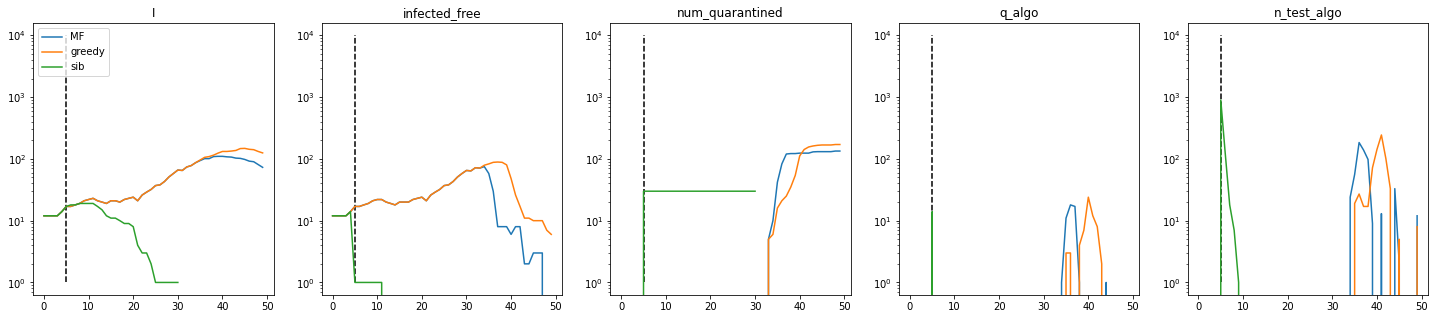

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
to_plot = ['I', 'infected_free', 'num_quarantined', "q_algo", "n_test_algo"]
for s in ress.keys():
    for il, l in enumerate(to_plot):
        if s != "no_intervention":
            axs[il].plot(range(T), ress[s][l], label=s)
            if l != "aurI":
                axs[il].set_yscale("log")
                axs[il].vlines(initial_steps, ymin=1, ymax=10**4,
                               linestyle="--", alpha=0.5, color="black")
            else:
                axs[il].vlines(initial_steps, ymin=0, ymax=1,
                               linestyle="--", alpha=0.5, color="black")

            axs[il].set_title(l, fontsize=12)
    axs[0].legend(loc='upper left')

#fig.suptitle(f"num test algo {num_test_algo} - adoption_fraction {adoption_fraction}")
fig.show()


In [11]:
import pandas as pd

object = pd.read_pickle('output_Tubingen_pop1_site1/MF_N_904_T_50_obs_300_sym_obs_0.05_seed_42_states.pkl')
object['transmissions']

[[[340.2019315565212, 70, 687], [131.95647805315014, 70, 767]],
 [],
 [],
 [],
 [[443.8642544391405, 457, 169], [446.58557659977487, 457, 859]],
 [],
 [[496.8092497974145, 425, 71]],
 [[180.7882932107915, 527, 811]],
 [[460.8312880643761, 811, 552],
  [351.8889250369396, 811, 706],
  [314.6034360979932, 811, 461]],
 [[273.9303402120962, 541, 20], [536.1035919047368, 541, 158]],
 [[369.49174753449853, 198, 325], [374.80358503279535, 459, 681]],
 [],
 [[557.962939520921, 278, 663]],
 [],
 [[556.5820615309623, 461, 853]],
 [],
 [[639.6565014806564, 706, 580],
  [701.1784311631366, 706, 638],
  [734.252565287945, 681, 765]],
 [[554.2869442363282, 20, 839]],
 [[447.0056726335478, 687, 682]],
 [[594.4993771964363, 682, 798], [626.8908180856051, 169, 849]],
 [[732.9198693227864, 859, 286],
  [712.5091095166881, 859, 42],
  [732.6007468673126, 859, 752]],
 [[746.3032298368565, 325, 265], [620.438682893206, 325, 576]],
 [[729.4342825283269, 513, 32],
  [831.1274271522934, 513, 748],
  [544.5702